
# Object detection on the PASCAL VOC 2007 dataset https://pjreddie.com/projects/pascal-voc-dataset-mirror/.

## Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import os
import numpy as np
import torch
from PIL import Image

## Loading dataset

In [ ]:
## Let's use the built-in tools and download the dataset for train and test into one folder, thereby getting the complete PASCALVOC 2007 dataset
datasets.VOCDetection(root="./data", year="2007",  image_set="train", download=True)
datasets.VOCDetection(root="./data", year="2007",  image_set="test", download=True)

Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data
Using downloaded and verified file: ./data/VOCtest_06-Nov-2007.tar
Extracting ./data/VOCtest_06-Nov-2007.tar to ./data


Dataset VOCDetection
    Number of datapoints: 4952
    Root location: ./data

## Secondary functions

In [ ]:
#Since, in the annotation, the label is represented as a string, not a numeric value,
# then for the model to work, we translate it ourselves.
CLASSES = {'dog': 1, 'person': 2, 'train': 3, 'sofa': 4,
           'chair': 5, 'car': 6, 'pottedplant': 7 , 'diningtable': 8,
           'horse': 9, 'cat': 10, 'cow': 11, 'bus': 12, 'bicycle': 13, 'aeroplane': 14,
           'motorbike': 15, 'tvmonitor': 16, 'bird': 17, 'bottle': 18, 'boat': 19, 'sheep': 20}

def get_class(labels, CLASSES):
  result = []
  for lab in labels:
    for cla in CLASSES:
      if lab == cla:
        result.append(CLASSES[cla])
  return result

In [ ]:
#Standard functions for saving and loading the model
def save_model(model, name_file):
  torch.save(model, name_file)

def load_model(path):
  return torch.load(path)

In [ ]:
#The annotation is presented as an xml file, so we use the following function to parse it
import xml.etree.ElementTree as ET
def get_annotation(xml_file: str):
    annotation = {}

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []
    labels = []

    for boxes in root.iter('object'):

        filename = root.find('filename').text
        labels.append(boxes.find('name').text)

        ymin, xmin, ymax, xmax = None, None, None, None
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes, labels

In [ ]:
## The training and testing functions were taken from the original repository and slightly modified.
import math
import sys
import time

import torch
import torchvision.models.detection.mask_rcnn
import utils
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset


def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    loss_for_draw = 0
    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()
        loss_for_draw += loss_value

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])


    return metric_logger, loss_for_draw/len(data_loader)


def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


@torch.inference_mode()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = "Test:"

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

In [ ]:
##Functions for visualizing dataset

import torchvision.transforms.functional as F
from torchvision.transforms.functional import convert_image_dtype

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def visual_image(img,boxes):
  img = convert_image_dtype(img, dtype=torch.uint8)
  show(torchvision.utils.draw_bounding_boxes(img,boxes, colors ='magenta', width=5))

def visual_origin_dataset(dataset):
  for i in range(len(dataset)):
    #boxes = dataset[i][1]['boxes']
    boxes = dataset[i][1]['boxes']
    img = dataset[i][0]
    visual_image(img,boxes)

def visual_predictions(img, prediction):
  boxes = prediction[0]['boxes']
  visual_image(img,boxes)

## Class for working with dataset

In [ ]:
import os
import numpy as np
import torch
from PIL import Image

class VOCPASCAL_2007(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms

        self.imgs = list(sorted(os.listdir(os.path.join(root, "JPEGImages"))))
        self.annotation = list(sorted(os.listdir(os.path.join(root, "Annotations"))))

    def __getitem__(self, idx):

        img_path = os.path.join(self.root, "JPEGImages", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        name, boxes, labels  = get_annotation(os.path.join(self.root, "Annotations",self.annotation[idx]))

        area = []
        iscrowd = []
        for box in boxes:
          area.append((box[2] - box[0]) * (box[3] - box[1]))
          iscrowd.append(0)


        lab = get_class(labels, CLASSES)
        target = {}
        target['boxes'] = torch.tensor(boxes,dtype=torch.double)
        target['labels'] = torch.tensor(lab, dtype=torch.long)
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.tensor(area)
        target['iscrowd'] = torch.tensor(iscrowd, dtype=torch.uint8)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    # transforms.append(T.ConvertImageDtype(torch.float))
    return T.Compose(transforms)

## Demonstration of dataset content

In [ ]:
dataset = VOCPASCAL_2007('/content/data/VOCdevkit/VOC2007', get_transform(train=True))

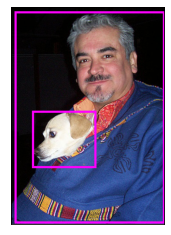

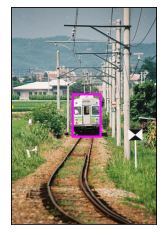

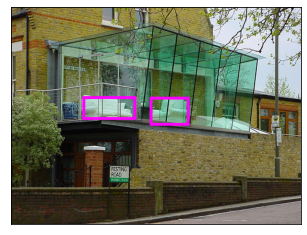

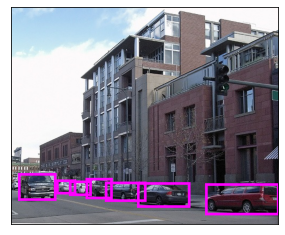

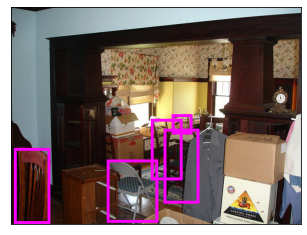

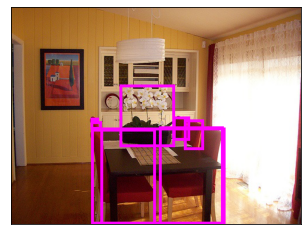

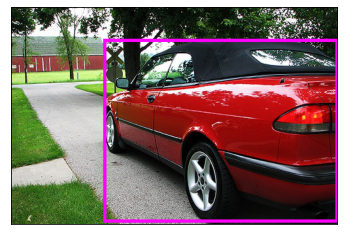

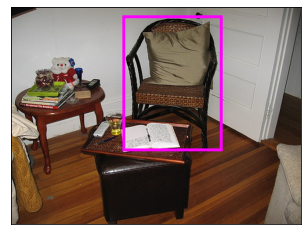

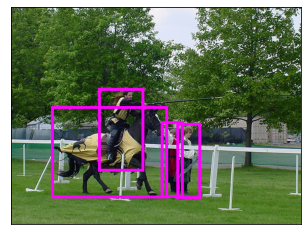

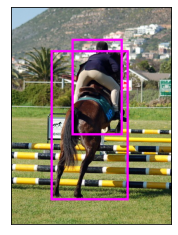

In [ ]:
for i in range(10):
  visual_image(dataset[i][0],dataset[i][1]['boxes'])

## Detection model

In [ ]:

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_instance_detection_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    print(model.parameters)
    return model

## Training

In [ ]:

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#There are 20 classes in our dataset, but don't forget about the background class.
num_classes = 21
# use our dataset and defined transformations
dataset = VOCPASCAL_2007('/content/data/VOCdevkit/VOC2007', get_transform(train=True))
data = VOCPASCAL_2007('/content/data/VOCdevkit/VOC2007', get_transform(train=False))
# Divide the dataset into 3 parts:
#training set, test set during training, and test set for final model evaluation
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-6500])

dataset_test = torch.utils.data.Subset(data, indices[-1000:])
dataset_val = torch.utils.data.Subset(data, indices[-6500:-6490])


In [ ]:

# define training and test data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)


data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_instance_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10
loss_for_draw = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    metrics, loss = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    loss_for_draw.append(loss)
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

<bound method Module.parameters of FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(25

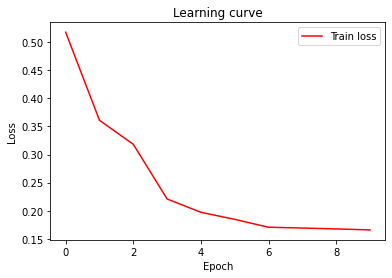

In [ ]:
## Learning curve
plt.plot(loss_for_draw, 'r')
plt.legend(['Train loss'])
plt.title("Learning curve")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Saving the Trained Model

In [ ]:
save_model(model, 'model_10epoch_finall')

## Testing

Models for detection problems are usually estimated using
mAP (mean average precision) metric, which is the average value
AP for each class and is fairly easy to interpret.

In [ ]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import numpy as np

def map_metric(model, dataset, device, metric = MeanAveragePrecision()):
  average_map = []
  for i in range(len(dataset)):
    target = []
    img, tar = dataset[i]
    target.append(tar)
    del target[0]['image_id']
    del target[0]['area']
    del target[0]['iscrowd']
    target[0]['boxes'] = target[0]['boxes'].to(device)
    target[0]['labels'] = target[0]['labels'].to(device)
    model.to(device)
    model.eval()
    prediction = model([img.to(device)])

    visual_predictions(img,prediction)

    metric.update(prediction, target)
    torch.cuda.synchronize()
    average_map.append(metric.compute()['map'])

  return average_map

In [ ]:
model = load_model("model_10epoch_finall")

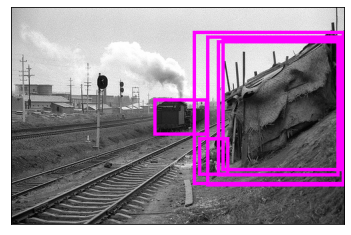

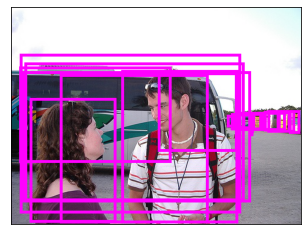

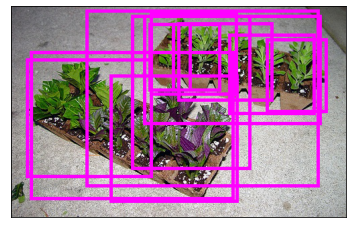

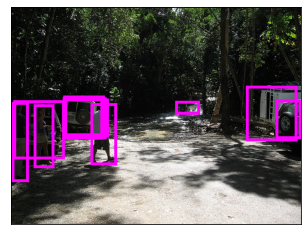

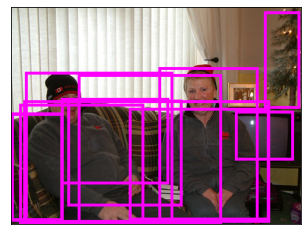

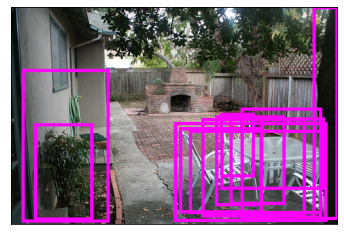

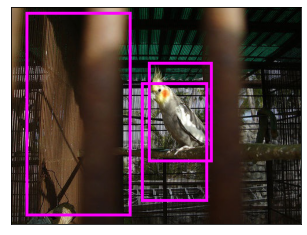

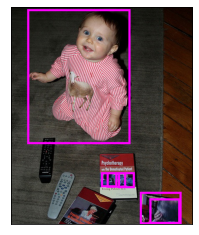

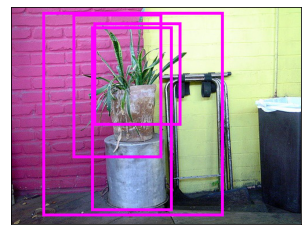

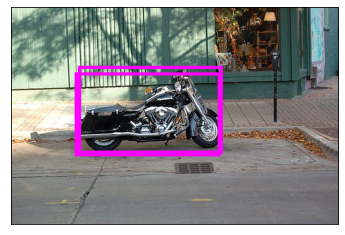

In [ ]:
mean = map_metric(model, dataset_val, device = device, metric = MeanAveragePrecision())

In [ ]:
sum = 0
for x in mean:
  sum += x.numpy()
print("Значение метрики mAP для тестовой выборки: ", sum/len(mean))

Значение метрики mAP для тестовой выборки:  0.6694778025150299


## Conclusion

The <b>Object Detection</b> task in the <b>Pascal Voc 2007</b> world has been removed. The standard <b>Faster R-CNN</b> model with the <b>ResNet-50-FPN</b> backbone was chosen.

The dataset was divided into <b>3 parts</b>: <i>training choice, test set for evaluation of models during training and test set for final evaluation of the model</i>. Also, the dataset was artificially limited in the number of images for each part, due to the lack of collab on the use of the GPU.

The training took place over <b>10 epochs</b>, this number of epochs was also mainly chosen in accordance with the constraints of the colab.

As a result, the accuracy of the model reached 0.66 for the <b>mAP</b> metric. This metric is the most popular in the field of detection and is well interpreted, so it was chosen.

To increase the accuracy of the model, the following approaches can be used:
<ul>
  <li>Increasing the training set</li>
  <li>Incrementing the number of epochs</li>
  <li>Working with hyperparameters</li>
  <li>Non-maximum suppression</li>
</ul>